Pradyumna Yadav (191010228)
Priyansh Sharma (191010230)
Sakshi Verma (191010239)

Kaggle dataset: Deepfake detection dataset: https://www.kaggle.com/c/deepfake-detection-challenge/data?select=train_sample_videos

# Mounting drive to access dataset


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [1]:
!pip install tensorflow==2.4.1

# Importing Libraries

In [2]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [3]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Pre-processing

In [ ]:
input_shape = (128, 128, 3)
data_dir = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(0)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(1)

X_pkl = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset/X_pkl.pkl'
Y_pkl = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset/Y_pkl.pkl'
with open(X_pkl,'wb') as f:
  pickle.dump(X,f)

with open(Y_pkl,'wb') as f:
  pickle.dump(Y,f)

In [4]:
input_shape = (128, 128, 3)
X_pkl = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset/X_pkl.pkl'
Y_pkl = '/content/gdrive/MyDrive/191010228_191010230_191010239/dataset/Y_pkl.pkl'

X = pickle.load(open(X_pkl,'rb'))
Y = pickle.load(open(Y_pkl,'rb'))

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

# VGG16

In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [6]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=2,verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
30/30 [==============================] - 45s 1s/step - loss: 0.5872 - accuracy: 0.6886 - val_loss: 0.5001 - val_accuracy: 0.7864
Epoch 2/20
30/30 [==============================] - 14s 465ms/step - loss: 0.4786 - accuracy: 0.7935 - val_loss: 0.4591 - val_accuracy: 0.7864
Epoch 3/20
30/30 [==============================] - 14s 462ms/step - loss: 0.4305 - accuracy: 0.7965 - val_loss: 0.3871 - val_accuracy: 0.8451
Epoch 4/20
30/30 [==============================] - 14s 459ms/step - loss: 0.3433 - accuracy: 0.8522 - val_loss: 0.3022 - val_accuracy: 0.8919
Epoch 5/20
30/30 [==============================] - 14s 463ms/step - loss: 0.2633 - accuracy: 0.9013 - val_loss: 0.3065 - val_accuracy: 0.8705
Epoch 6/20
30/30 [==============================] - 14s 464ms/step - loss: 0.2413 - accuracy: 0.9020 - val_loss: 0.2477 - val_accuracy: 0.8945
Epoch 7/20
30/30 [==============================] - 14s 469ms/step - loss: 0.1805 - accuracy: 0.9340 - val_loss: 0.1753 - val_accuracy: 0.9279
Ep

# Plotting metrics

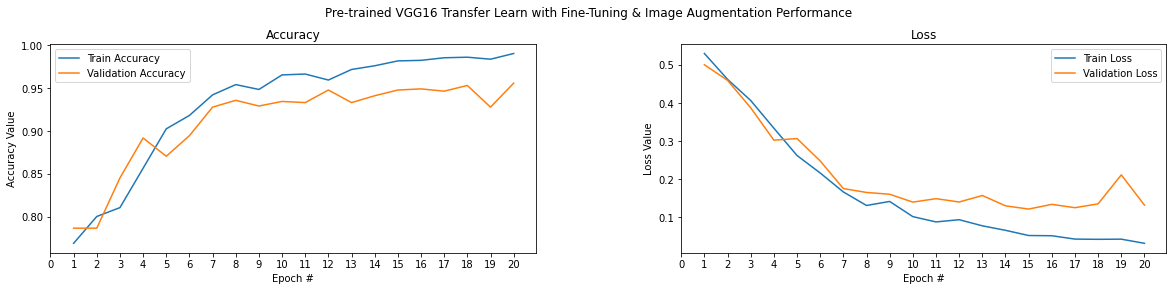

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained VGG16 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


True positive =  727
False positive =  32
False negative =  33
True negative =  2953




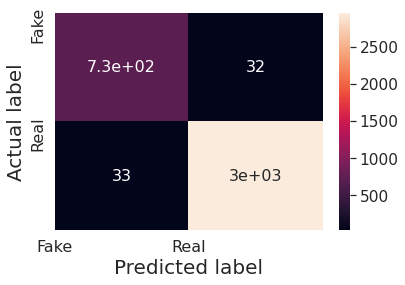

In [8]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    """
    Plots confusion matrix

    This function gives the rconfusion matrix as output in form of heatmap

    Returns
    -------
    None
    Arguments
    ----------
    y_true: list
    y_pred: list

    """
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val_org, model.predict_classes(X))

# Saving model

In [9]:
model.save('/content/gdrive/MyDrive/191010228_191010230_191010239/deepfake-detection-model-vgg.h5')